In [1]:
import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow

from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers
import keras

from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn import metrics
from keras import regularizers
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
vgg16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [3]:
data = np.load('../input/cnn-data-new/Train_RAW_v2.npz')

In [4]:
test_data = np.load('../input/cnn-data-new/Test_RAW_v2.npz')

In [5]:
X_test = test_data['features']
Y_test = test_data['labels']

In [6]:
data.files

['features', 'labels']

In [7]:
features = data['features']
labels = data['labels']

In [8]:
train_features = vgg16.predict(np.array(features), batch_size=256, verbose=1)

12644/12644 [==============================] - 23s 2ms/step


In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(train_features, labels, test_size=0.20, random_state=42)

In [10]:
X_test_tl = vgg16.predict(np.array(X_test), batch_size=256, verbose=1)

1406/1406 [==============================] - 3s 2ms/step


In [11]:
# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation="softmax"))

In [12]:
# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [13]:
history = model.fit(X_train, Y_train,batch_size=256,epochs=50,verbose=1,validation_data=(X_val, Y_val))

Train on 10115 samples, validate on 2529 samples
Epoch 1/50
10115/10115 [==============================] - 0s 36us/step - loss: 2.5954 - accuracy: 0.6804 - val_loss: 0.6837 - val_accuracy: 0.7746
Epoch 2/50
10115/10115 [==============================] - 0s 15us/step - loss: 0.7904 - accuracy: 0.7281 - val_loss: 0.5361 - val_accuracy: 0.7643
Epoch 3/50
10115/10115 [==============================] - 0s 14us/step - loss: 0.5217 - accuracy: 0.7597 - val_loss: 0.4629 - val_accuracy: 0.7746
Epoch 4/50
10115/10115 [==============================] - 0s 14us/step - loss: 0.4726 - accuracy: 0.7784 - val_loss: 0.4547 - val_accuracy: 0.7841
Epoch 5/50
10115/10115 [==============================] - 0s 14us/step - loss: 0.4461 - accuracy: 0.7866 - val_loss: 0.4457 - val_accuracy: 0.7920
Epoch 6/50
10115/10115 [==============================] - 0s 14us/step - loss: 0.4276 - accuracy: 0.7955 - val_loss: 0.4422 - val_accuracy: 0.7904
Epoch 7/50
10115/10115 [==============================] - 0s 14us/ste

# Predictions on Test Data

In [14]:
# Cross-Validation Predictions
test_results = model.evaluate(X_test_tl,Y_test)
y_pred = model.predict_classes(X_test_tl)

print('\nTest Results')
print('Test Accuracy %.2f%%' % (metrics.accuracy_score(Y_test, y_pred)*100))

1406/1406 [==============================] - 0s 53us/step

Test Results
Test Accuracy 81.08%


# Visualise Results

## Train Validation Accuracy

In [15]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

KeyError: 'acc'

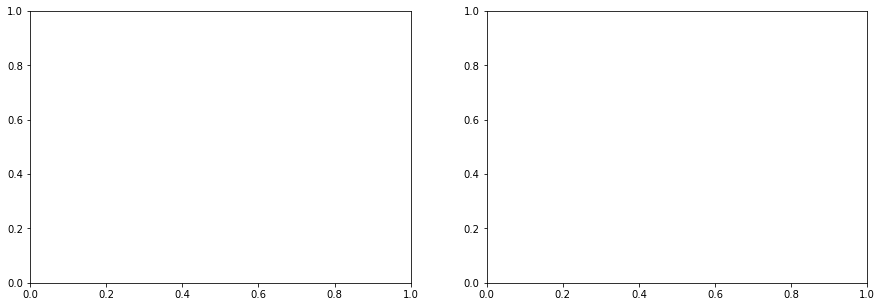

In [16]:
plot_model_history(history)

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 4))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=12,weight='bold')
    #plt.legend('off')
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0,fontsize=12,weight='bold')
        plt.yticks(tick_marks, target_names,fontsize=12,weight='bold')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=12,weight='bold')
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=12,weight='bold')
    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,weight='bold')
    plt.xlabel('\n Predicted label \n Test accuracy={:0.2f}%; Misclass={:0.2f}%'.format(accuracy*100, misclass*100),fontsize=12,weight='bold')
    #plt.get_legend().remove()
    
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
plot_confusion_matrix(cm = cm,normalize= False,cmap ='binary',target_names = ['nocancer', 'cancer'],
                      title= '')

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_test, y_pred, target_names=['nocancer','cancer'])

print(report)

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_test,y_pred).ravel()
print(tn, fp, fn, tp)

In [ ]:
print("Sensitivity %.2f%%" % ((tp / (tp + fn))*100))

In [ ]:
print("F1-score %.2f%%" % (metrics.f1_score(Y_test, y_pred)*100))

In [ ]:
print("Specificity %.2f%%" % ((tn / (tn + fp))*100))